# Fake News Detection Using Natural Language Processing (NLP) and Classification Modeling

### Contents
- [**Importing Libraries**](#Import-Libraries)
- [**Data Scrape**](#Data-Scrape)
 - [API Scrape Function](#API-Scrape-Function)
 - [Scrape r/notheonion](#Scrape-r/nottheonion)
 - [Scrape r/TheOnion](#Scrape-r/TheOnion)
- [**Import Data**](#Import-Data)
 - [Preview `df_onion`](#Preview-df_onion)
- [**Clean Data**](#Clean-Data)
 - [Data Cleaning Function](#Data-Cleaning-Function)
 - [Clean `df_onion`](#Clean-df_onion)
 - [Clean `df_not_onion`](#Clean-df_not_onion)
 - [Check Nulls](#Check-Nulls)
- [**Exploratory Data Analysis (EDA)**](#Exploratory-Data-Analysis-(EDA))
 - [Data Range of Scraped Posts](#Data-Range-of-Scraped-Posts)
 - [Bar Plot Function](#Bar-Plot-Function)
 - [r/TheOnion: Most Active Authors](#r/TheOnion:-Most-Active-Authors)
 - [r/nottheonion: Most Active Authors](#r/nottheonion:-Most-Active-Authors)
 - [r/TheOnion: Most Referenced Domains](#r/TheOnion:-Most-Referenced-Domains)
 - [r/nottheonion: Most Referenced Domains](#r/nottheonion:-Most-Referenced-Domains)
- [**Natural Language Processing (NLP)**](#Natural-Language-Processing-(NLP))
 - [Concatenate DataFrames](#Concatenate-DataFrames)
 - [Binarize Target `subreddit`](#Binarize-Target-subreddit)
 - [Apply `CountVectorizer()`](#Apply-CountVectorizer())
 - [r/TheOnion: Top 5 Unigrams](#r/TheOnion:-Top-5-Unigrams)
 - [r/nottheonion: Top 5 Unigrams](#r/nottheonion:-Top-5-Unigrams)
 - [r/nottheonion: Top 5 Bigrams](#r/nottheonion:-Top-5-Bigrams)
 - [r/nottheonion: Top 5 Bigrams](#r/nottheonion:-Top-5-Bigrams)
 - [Create custom `stop_words` to include common frequent words](#Create-custom-stop_words-to-include-common-frequent-words)
- [**Modeling**](#Modeling)
 - [Baseline Score](#Baseline-Score)
 - [Set `X` (predictor) and `y` (target) variables](#Set-X-(predictor)-and-y-(target)-variables)
 - [Train/Test Split](#Train/Test-Split)
 - [Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)](#Model-1:-CountVectorizer-&-Logistic-Regression-(Best-Coefficient-Interpretability))
 - [Model 2: TfidfVectorize & Logistic Regression](#Model-2:-TfidfVectorize-&-Logistic-Regression)
 - [Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)](#Model-3:-CountVectorizer-&-MultinomialNB-(Best-Accuracy-Score))
 - [Model 4: TfidfVectorizer & MultinomialNB](#Model-4:-TfidfVectorizer-&-MultinomialNB)
- [**Best Models**](#Best-Models)
 - [CountVectorizer & MultinomialNB: Best Score](#CountVectorizer-&-MultinomialNB:-Best-Score)
 - [Confusion Matrix](#Confusion-Matrix)
 - [CountVectorizer & Logistic Regression: Best Coefficient Interpretability](#CountVectorizer-&-Logistic-Regression:-Best-Coefficient-Interpretability)
 - [Coefficient Analysis](#Coefficient-Analysis)
- [**Conclusions and Next-Steps**](#Conclusions-and-Next-Steps)

# Import Libraries

In [2]:
!pip install psaw

In [7]:
# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


# Data Scrape

I chose to scrape posts from r/TheOnion and r/nottheonion in order to create a fake news model that could accurately distinguish between fake news and absurd news. From each subbreddit I scraped the following information:  
 - `title`: title of subreddit post 
 - `subreddit`: which subreddit the post belongs to 
 - `num_comments`: the number of comments for a post 
 - `author`: author's username of a post
 - `subreddit_subcribers`: number of subcribers for that subreddit 
 - `score`: the score received on reddit 
 - `domain`: the domain referenced in the post 
 - `created_utc`: date and time the post was created

In total, 29,867 posts were scraped: 15k from r/nottheonion and 14,867 from r/TheOnion. 

_Hat tip: [David Capella](http://davidcapella.com/) for sharing with me how to use Pushshift_

### API Scrape Function

In [8]:
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=15000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

### Scrape r/nottheonion

In [9]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')

# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

nottheonion subscribers: 18954949
df_not_onion shape: (15000, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,string_in_database,reuters.com,Meet the woman shaping post-pandemic cybersex,0,1,1616001327
1,nottheonion,nehal4,huffingtonpost.co.uk,UK Foreign Secretary wants trade deals with na...,1,1,1616001127
2,nottheonion,howlingDef,bbc.com,Elon Musk changes job title to 'Technoking of ...,0,1,1616000867
3,nottheonion,LArenotaNEWS,larenota.com,Trump to headline fundraiser for ex-aide tough...,0,1,1616000368
4,nottheonion,BrautanGud,rawstory.com,‘I don’t feel comfortable giving you money’: B...,1,1,1616000274


### Scrape r/TheOnion

In [10]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

theonion subscribers: 159688
df_onion shape: (14978, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,ThatsMyPhoenix,theonion.com,"‘No Way To Prevent This,’ Says Only Nation Whe...",1,1,1615997220
1,TheOnion,Brosie-Odonnel,theonion.com,Irish-Americans Gear Up For 'The Reinforcin' O...,0,1,1615996419
2,TheOnion,dwaxe,ogn.theonion.com,Loving Support: This Man Brought His Xbox To T...,4,1,1615982708
3,TheOnion,thebelsnickle1991,theonion.com,Saints Quarterback Drew Brees Retires After 20...,0,1,1615920778
4,TheOnion,PoetryDefendant,theonion.com,"‘It’s Good To Practice Some Self Care,’ Says M...",1,1,1615919373


# Import Data

In [11]:
# If you're running this notebook, you can begin with this cell as the data has already been saved to a csv

# r/TheOnion DataFrame
df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('./data/not_onion.csv')

### Preview `df_onion`

In [12]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head()

Shape: (14978, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,ThatsMyPhoenix,theonion.com,"‘No Way To Prevent This,’ Says Only Nation Whe...",1,1,1615997220
1,1,TheOnion,Brosie-Odonnel,theonion.com,Irish-Americans Gear Up For 'The Reinforcin' O...,0,1,1615996419
2,2,TheOnion,dwaxe,ogn.theonion.com,Loving Support: This Man Brought His Xbox To T...,4,1,1615982708
3,3,TheOnion,thebelsnickle1991,theonion.com,Saints Quarterback Drew Brees Retires After 20...,0,1,1615920778
4,4,TheOnion,PoetryDefendant,theonion.com,"‘It’s Good To Practice Some Self Care,’ Says M...",1,1,1615919373


### Preview `df_not_onion`

In [13]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head()

Shape: (15000, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,string_in_database,reuters.com,Meet the woman shaping post-pandemic cybersex,0,1,1616001327
1,1,nottheonion,nehal4,huffingtonpost.co.uk,UK Foreign Secretary wants trade deals with na...,1,1,1616001127
2,2,nottheonion,howlingDef,bbc.com,Elon Musk changes job title to 'Technoking of ...,0,1,1616000867
3,3,nottheonion,LArenotaNEWS,larenota.com,Trump to headline fundraiser for ex-aide tough...,0,1,1616000368
4,4,nottheonion,BrautanGud,rawstory.com,‘I don’t feel comfortable giving you money’: B...,1,1,1616000274


# Clean Data

### Data Cleaning Function

In [14]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

### Clean `df_onion`

In [15]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (13893, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,ThatsMyPhoenix,theonion.com,no way to prevent this says only nation where...,1,1,1615997220
1,1,TheOnion,Brosie-Odonnel,theonion.com,irish americans gear up for the reinforcin o t...,0,1,1615996419
2,2,TheOnion,dwaxe,ogn.theonion.com,loving support this man brought his xbox to th...,4,1,1615982708
3,3,TheOnion,thebelsnickle1991,theonion.com,saints quarterback drew brees retires after se...,0,1,1615920778
4,4,TheOnion,PoetryDefendant,theonion.com,it s good to practice some self care says man...,1,1,1615919373


### Clean `df_not_onion`

In [16]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (11657, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,string_in_database,reuters.com,meet the woman shaping post pandemic cybersex,0,1,1616001327
1,1,nottheonion,nehal4,huffingtonpost.co.uk,uk foreign secretary wants trade deals with na...,1,1,1616001127
2,2,nottheonion,howlingDef,bbc.com,elon musk changes job title to technoking of t...,0,1,1616000867
3,3,nottheonion,LArenotaNEWS,larenota.com,trump to headline fundraiser for ex aide tough...,0,1,1616000368
4,4,nottheonion,BrautanGud,rawstory.com,i don t feel comfortable giving you money bla...,1,1,1616000274


### Check Nulls

In [17]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
Unnamed: 0,0,0
subreddit,0,0
author,0,0
domain,0,0
title,0,0
num_comments,0,0
score,0,0
timestamp,0,0


# Exploratory Data Analysis (EDA)

### Date Range of Scraped Posts

In [18]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2016-12-06 18:45:23
TheOnion end date: 2021-03-17 16:07:00
nottheonion start date: 2020-12-29 22:19:32
nottheonion end date: 2021-03-17 17:15:27


### Bar Plot Function

In [19]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

### r/TheOnion: Most Active Authors

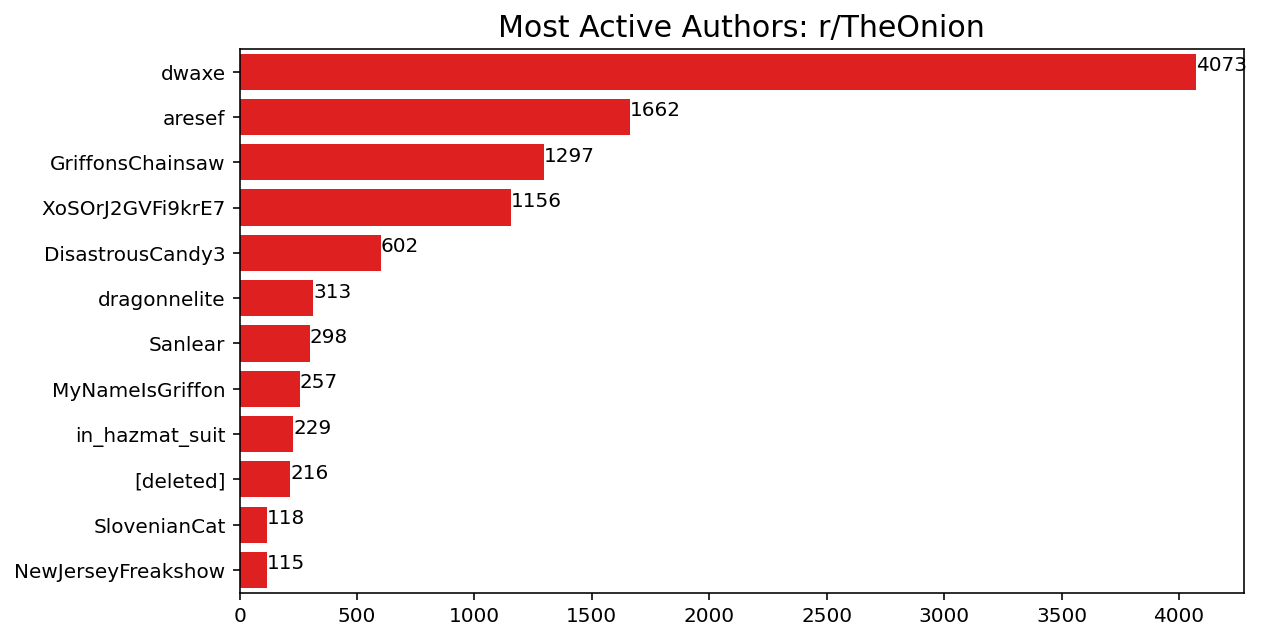

In [20]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r') 

r/TheOnion has only 95k subscribers, but 14 authors shared over 100 posts, the most being 4,113 posts.

### r/nottheonion: Most Active Authors

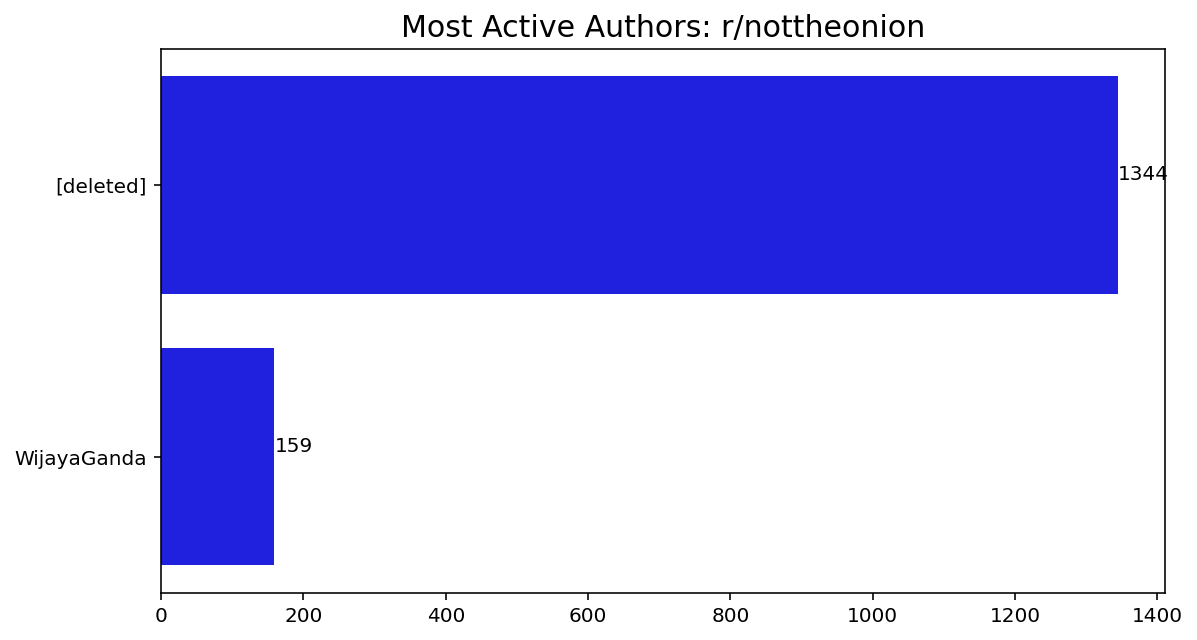

In [21]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b') 

r/nottheonion has 15m subscribers, and only 3 authors shared over 100 posts.   

### r/TheOnion: Most Referenced Domains

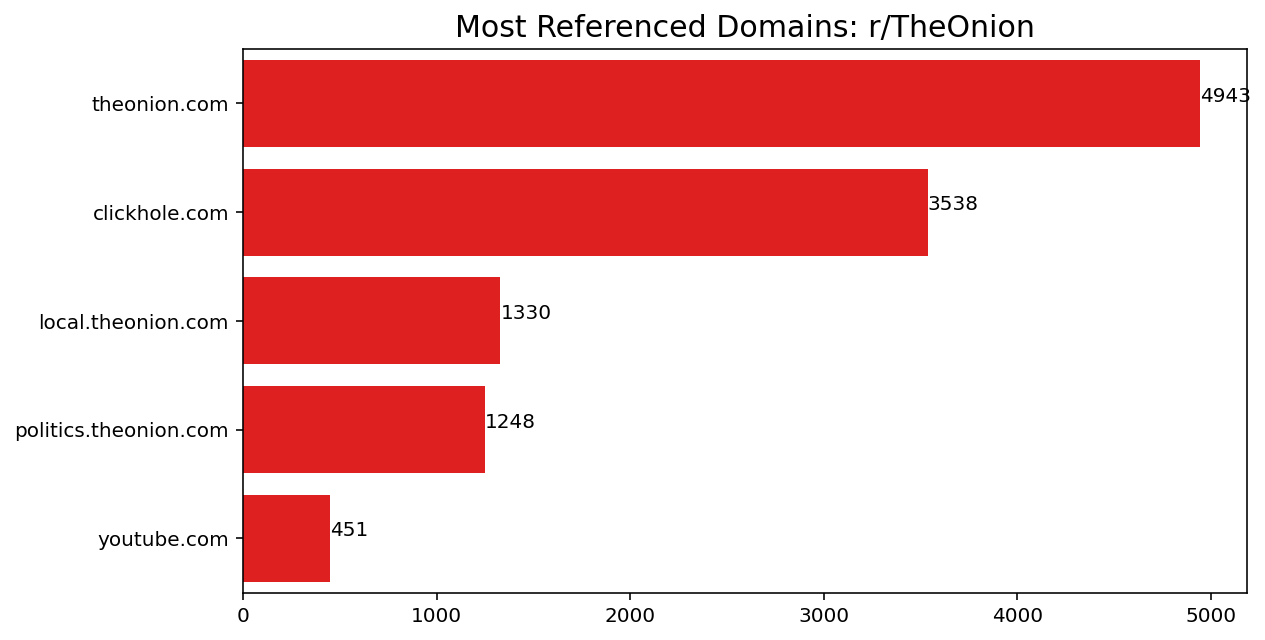

In [22]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r') 

Unsurprisingly, the most referenced domains from r/TheOnion are from The Onion. This subreddit allows articles from other news satire sites to be shared here as well.

### r/nottheonion: Most Referenced Domains

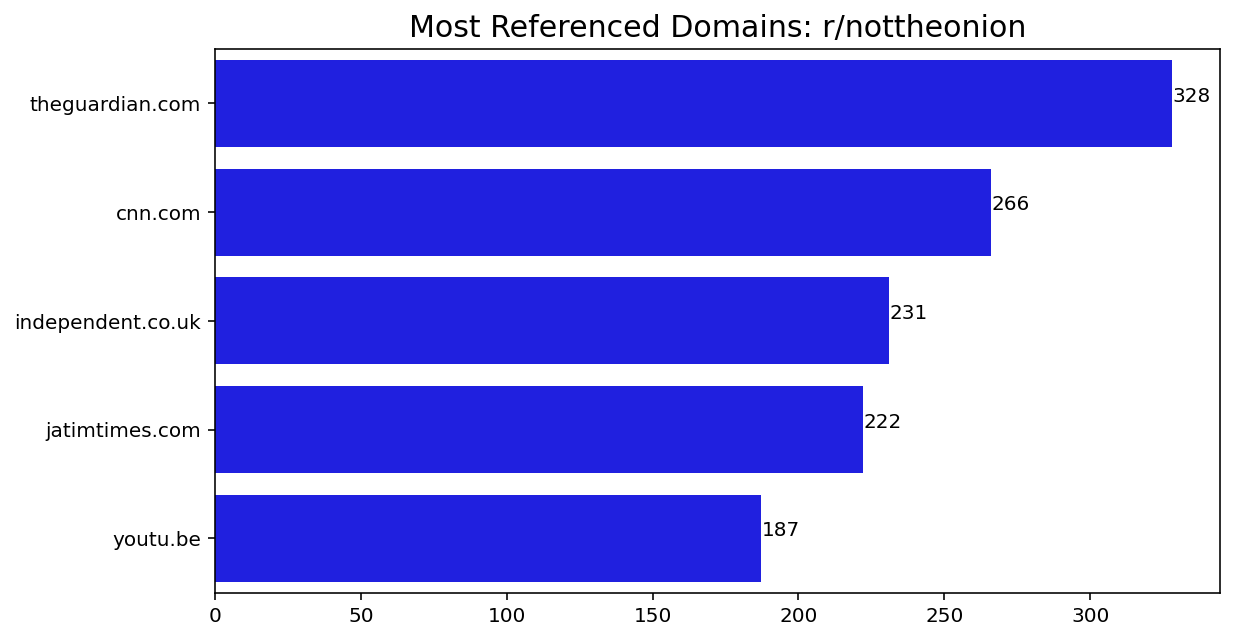

In [23]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b') 

Also unsurprisingly, foxnews.com is the most referenced domain in r/nottheonion! 

# Natural Language Processing (NLP)

Here I use Count Vectorizer to continue my EDA and explore the most used words and combinations of words from each subreddit. 

### Concatenate DataFrames

In [24]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,no way to prevent this says only nation where...
1,TheOnion,irish americans gear up for the reinforcin o t...


In [25]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
25548,nottheonion,spat between boulder weld leaders over covid h...
25549,nottheonion,student with hh boobs crowdfunds to raise mone...


### Binarize Target `subreddit`
 - `TheOnion`: 1
 - `nottheonion`: 0

In [26]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(25550, 2)


,subreddit,title
0,1,no way to prevent this says only nation where...
1,1,irish americans gear up for the reinforcin o t...


In [27]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
25548,0,spat between boulder weld leaders over covid h...
25549,0,student with hh boobs crowdfunds to raise mone...


## Apply `CountVectorizer()`

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (1,1)`

In [28]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(13893, 16112)


In [1]:
CountVectorizer?

Object `CountVectorizer` not found.


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (1,1)`

In [29]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11657, 15165)


### r/TheOnion: Top 5 Unigrams 

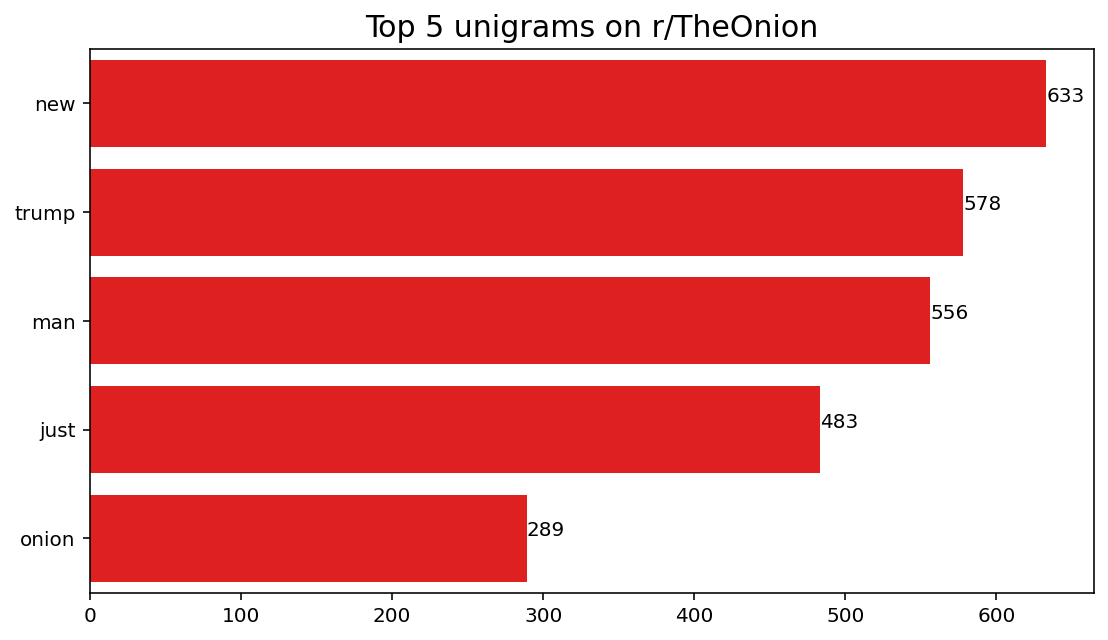

In [30]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Unigrams

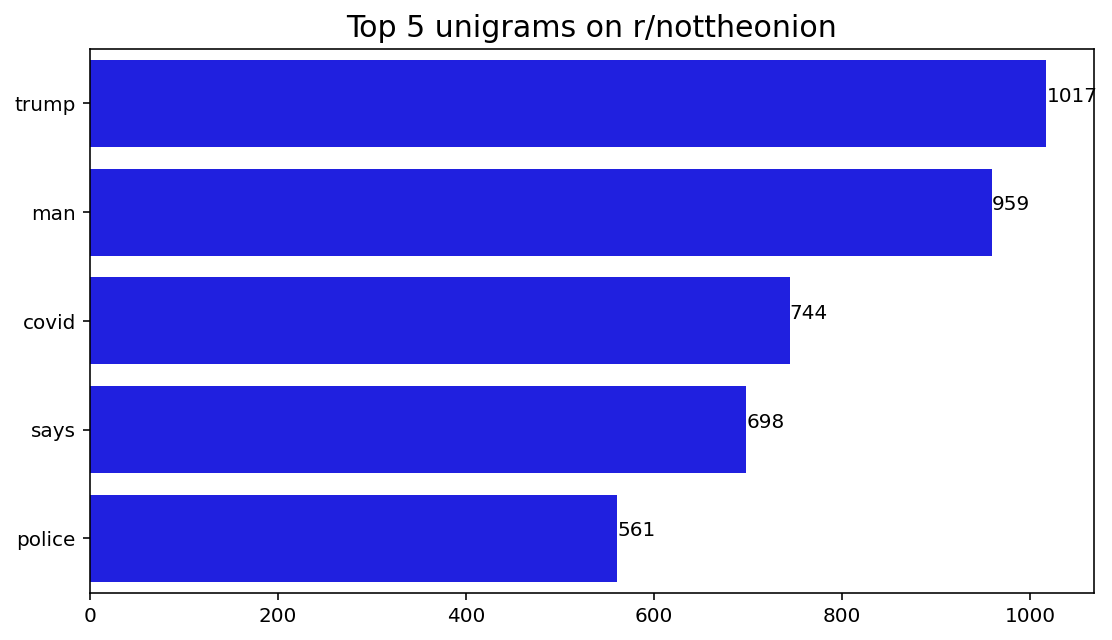

In [31]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b') 

### Common Unigrams between Top 5 in r/TheOnion & r/nottheonion

In [32]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

### Count Vectorize `df` where `subreddit` is `1`
 - `ngram_range = (2,2)`

In [33]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(13893, 60172)


### Count Vectorize `df` where `subreddit` is `0`
 - `ngram_range = (2,2)`

In [34]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11657, 62456)


### r/TheOnion: Top 5 Bigrams

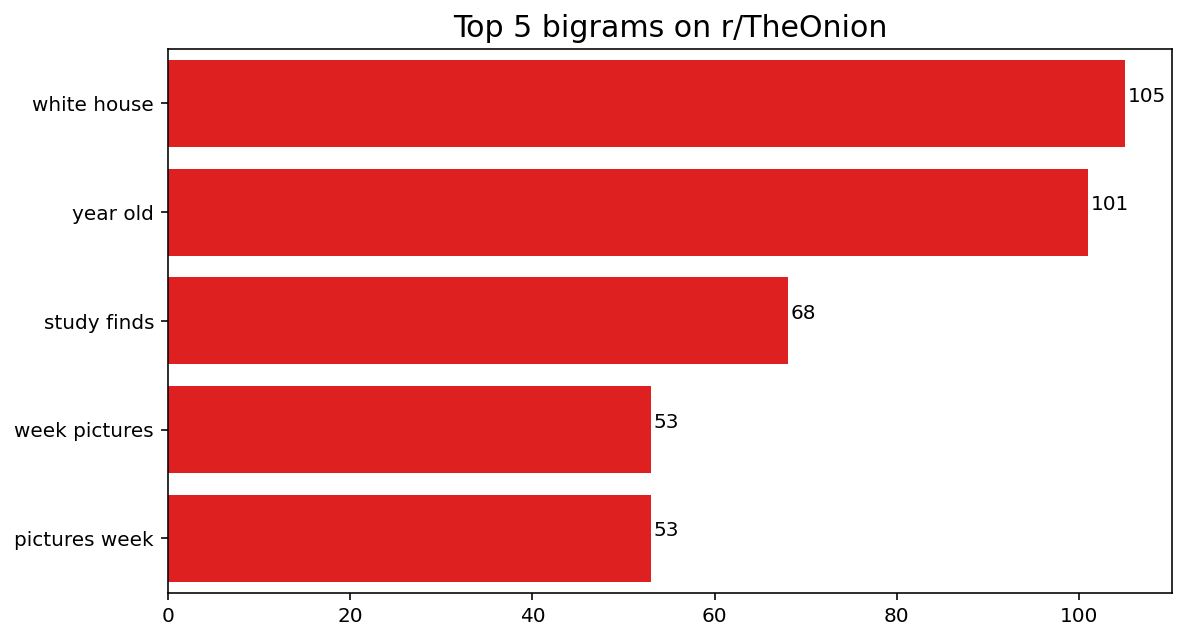

In [35]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r') 

### r/nottheonion: Top 5 Bigrams

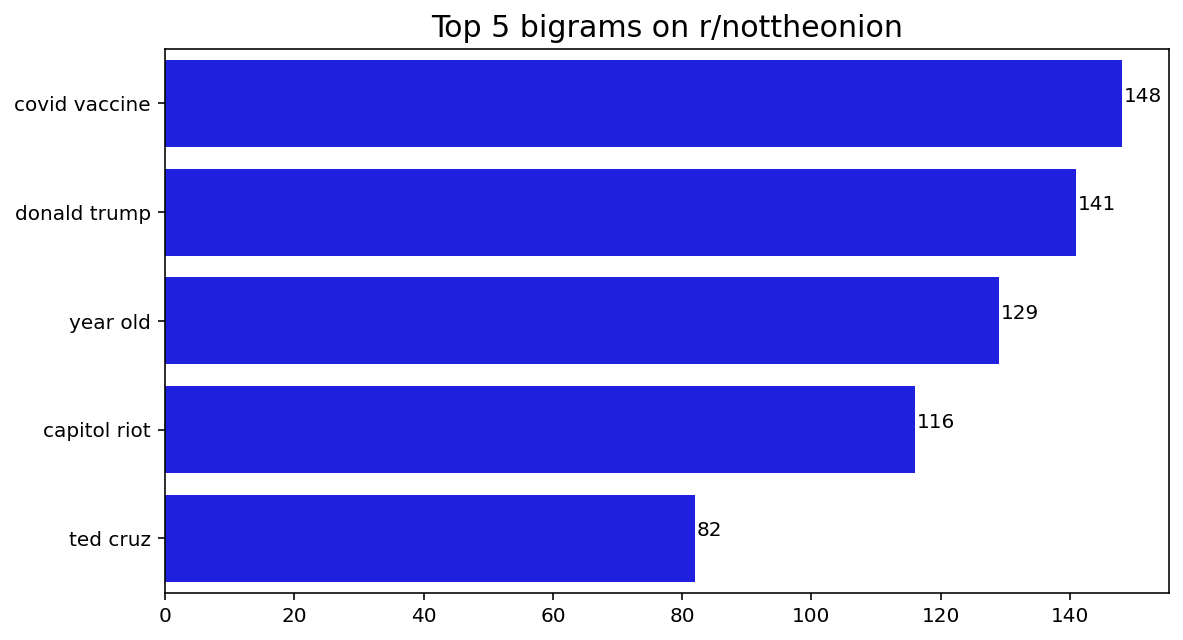

In [36]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b') 

### Common Bigrams between Top 5 in r/TheOnion & r/nottheonion

In [37]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

{'year old'}

Take out `{'man', 'new', 'old', 'people', 'say', 'trump', 'woman', 'year'}` from dataset when modeling, since these words occur frequently in both subreddits. 

### Create custom `stop_words` to include common frequent words

Referencing the common most-used words, add them to a customized `stop_words` list. 

In [39]:
# Create lists 
custom = _stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

# Modeling

Here I conduct model-prep and use Pipeline and GridSearch to determine the most optimal model to run my data on. 

### Baseline Score

In [40]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.543757
0    0.456243
Name: subreddit, dtype: float64

I expect my model to be better than 54%. The majority class is `1`, or, `TheOnion`. If the model is not better than 54%, I know the model is not performing well.

### Set `X` (predictor) and `y` (target) variables 

In [41]:
X = df['title']
y = df['subreddit']

### Train/Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1: CountVectorizer & Logistic Regression 

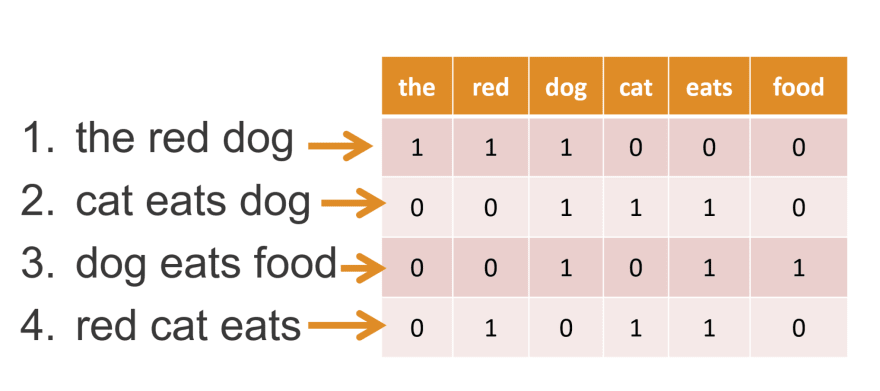

In [2]:
from IPython.display import Image
Image("countvectorizer.png")

In [43]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8277838774276582
Train score 0.9564241728420833
Test score 0.8501878522229179


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

Throughout my model testing, none of the stop_word lists were chosen as a best parameter. So from here on out, I omit them from my parameter selection. Additionally, while the model is overfit, I am optimizing to get the highest accuracy score in my test set. 

### Model 2: TfidfVectorize & Logistic Regression

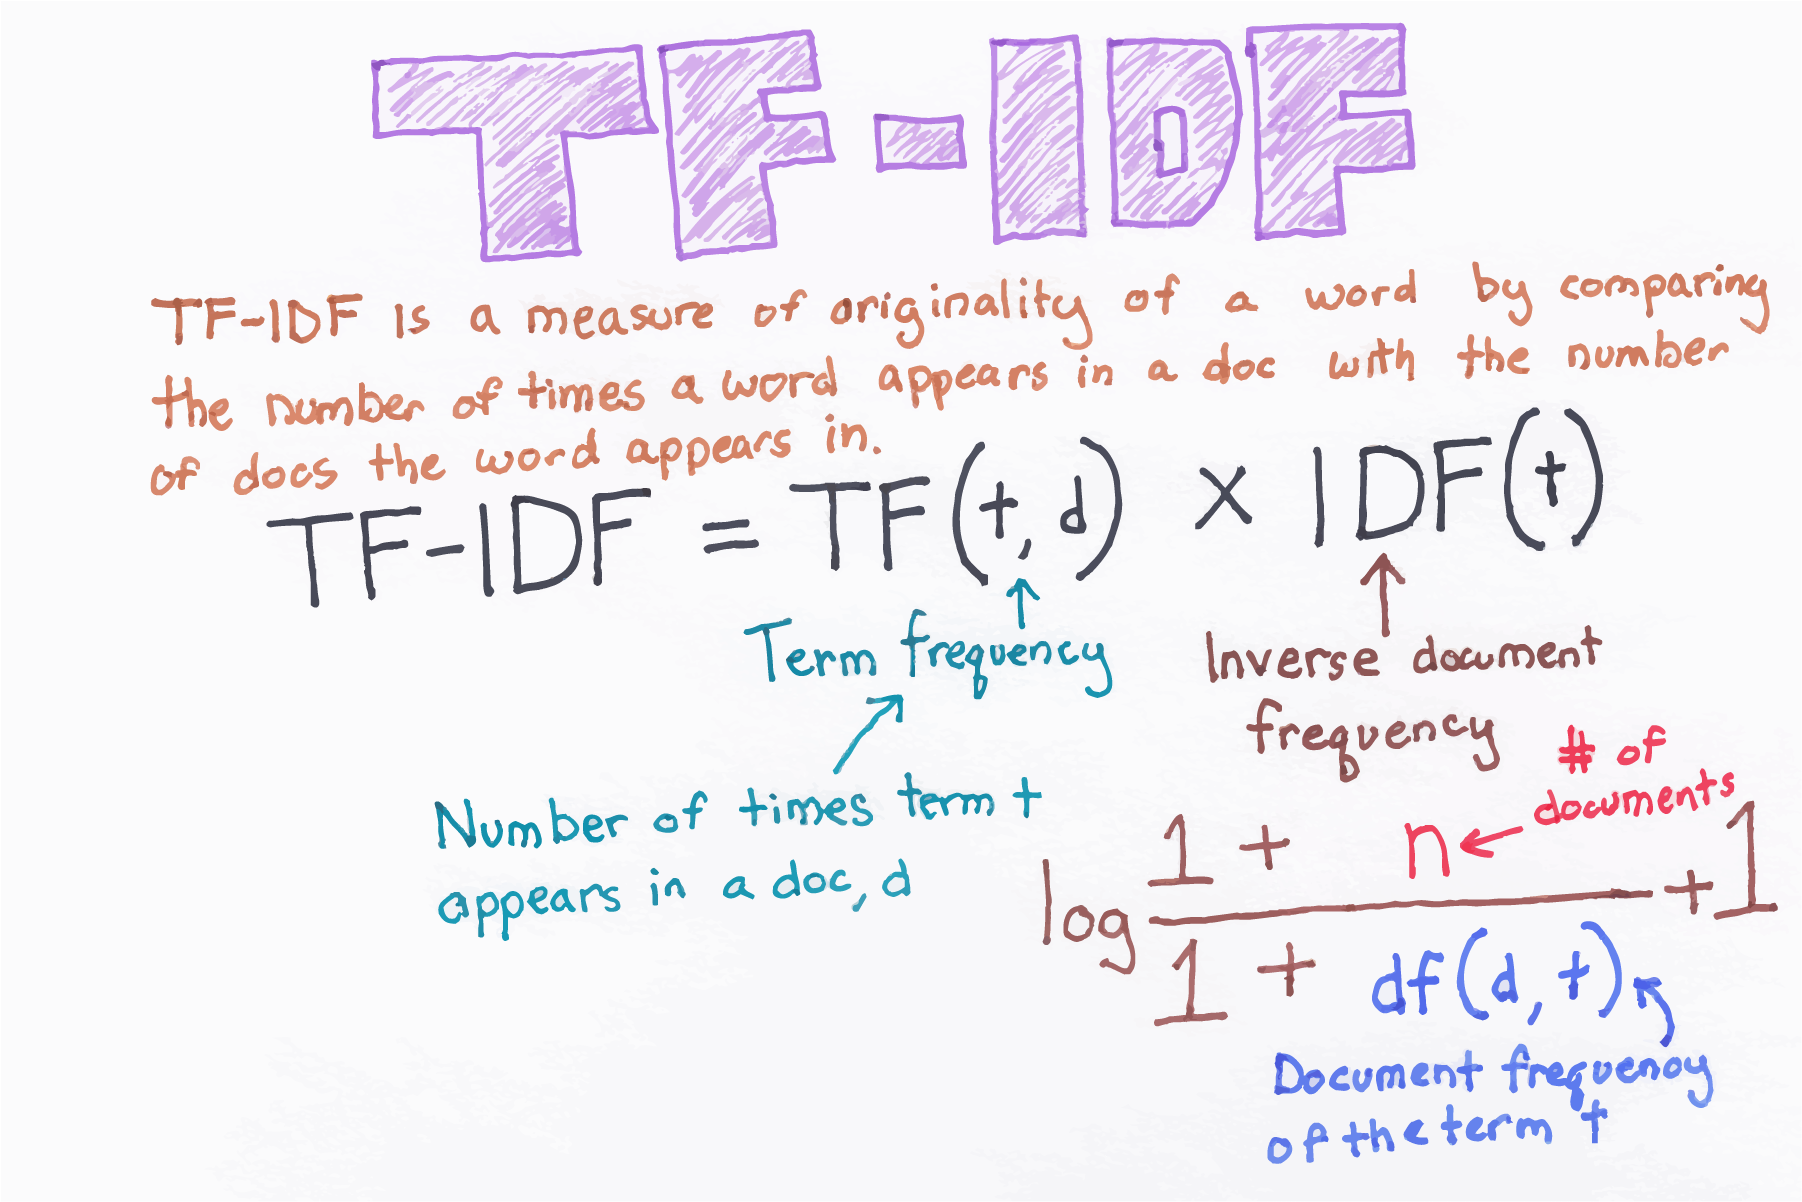

In [3]:
Image("tfidf.png")

In [44]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8227741253407626
Train score 0.9075253105103851
Test score 0.8389167188478397


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 3,
 'tvect__ngram_range': (1, 3)}

This model is also overfit. However, Model 1 performed with a better test score when comparing Logistic Regression models. 

### Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)

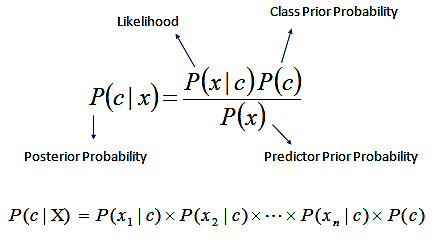

In [4]:
Image("nb.png")

In [45]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8556519898273591
Train score 0.9932157394843962
Test score 0.8722604884157796


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

The model is overfit, but as I mentioned, I am optimizing for accuracy. I want to ensure that all predictions are correct. That is, all posts from r/TheOnion must be classified as being from the subreddit r/TheOnion, and all posts from r/nottheonion must be classified as being from the subreddit r/nottheonion. This model gave me my best test accuracy score. 

### Model 4: TfidfVectorizer & MultinomialNB 

In [46]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8351947323730247
Train score 0.9077340569877883
Test score 0.8458046336881653


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

This model is overfit. When comparing test scores of my MultinomialNB models, Model 3 performs better.

# Best Models 

In this section, I take my two optimal models and run them. The first model, CountVectorizer & MultinomialNB, will be used to convey a confusion matrix which will show all evaluation scores. The second model, CountVectorizer & Logistic Regression, will be used to interpret my coefficients.

### CountVectorizer & MultinomialNB: Best Score

In [47]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8722604884157796


### Confusion Matrix

In [48]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2458,  456],
       [ 360, 3114]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

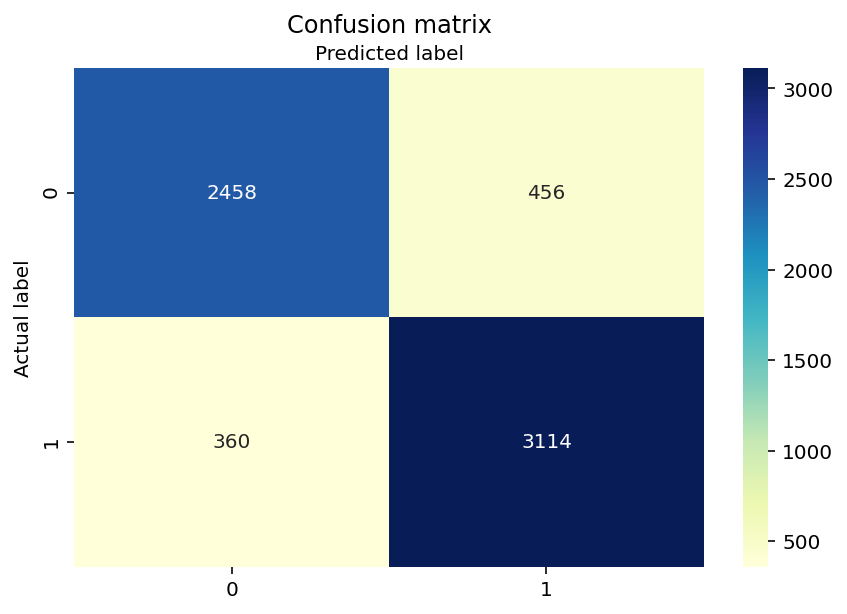

In [49]:
# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [51]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 87.23 %
Precision: 87.23 %
Recall: 89.64 %
Specificity: 84.35 %
Misclassification Rate: 14.24 %


### CountVectorizer & Logistic Regression: Best Coefficient Interpretability

In [53]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = _stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [54]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8346900438321854


### Coefficient Analysis

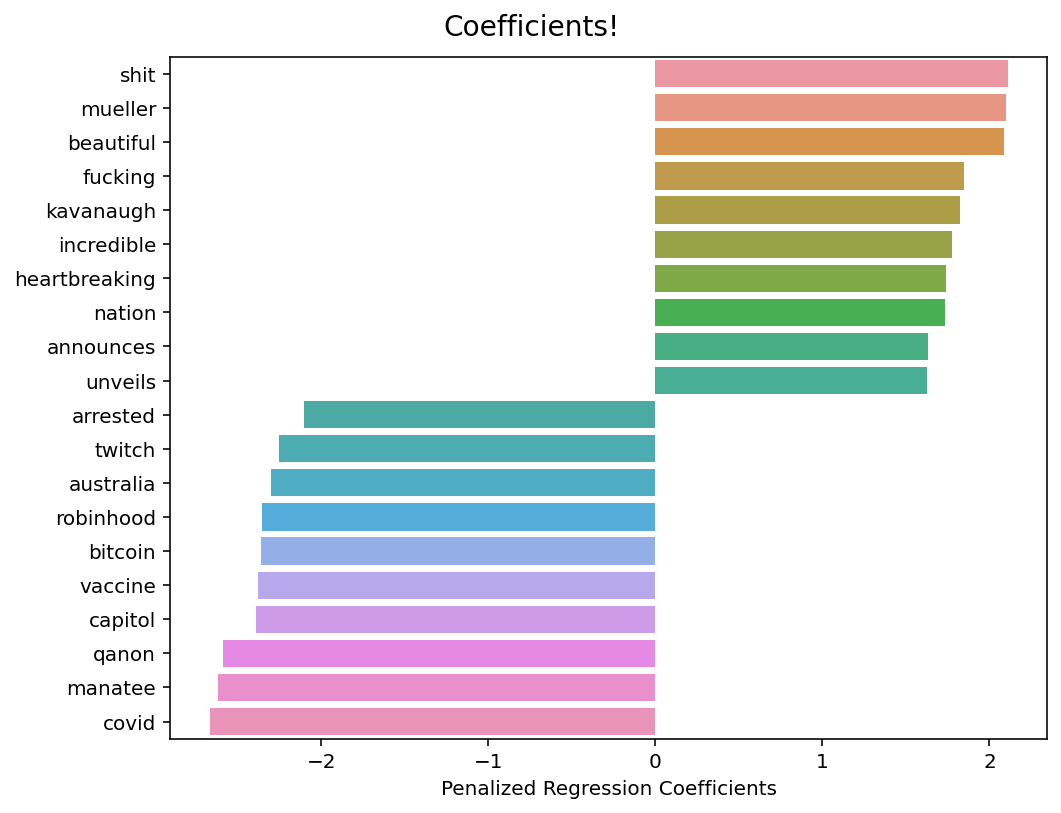

In [55]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

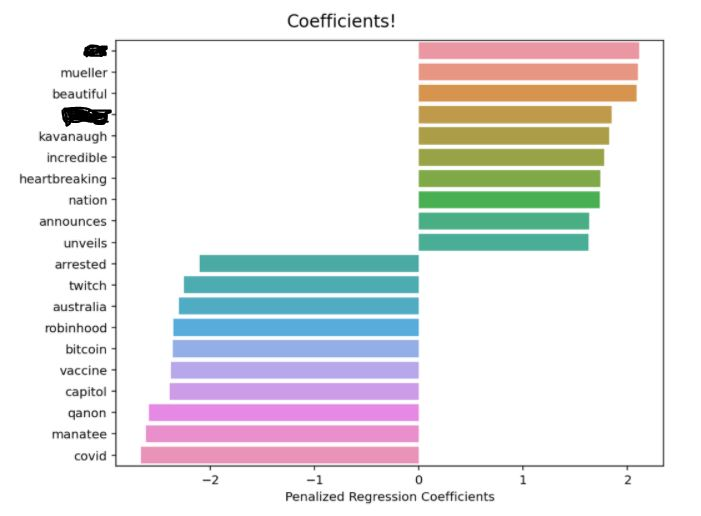

In [6]:
Image("Coeff.jpg")

In [56]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is shit followed by mueller and beautiful .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is covid followed by manatee and qanon .


In [57]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
shit,2.108,8.231761
mueller,2.098,8.149854
beautiful,2.089,8.076834
fucking,1.849,6.353463
kavanaugh,1.821,6.178033
incredible,1.774,5.894384
heartbreaking,1.740,5.697343
nation,1.734,5.663262
announces,1.632,5.114093
unveils,1.625,5.078419


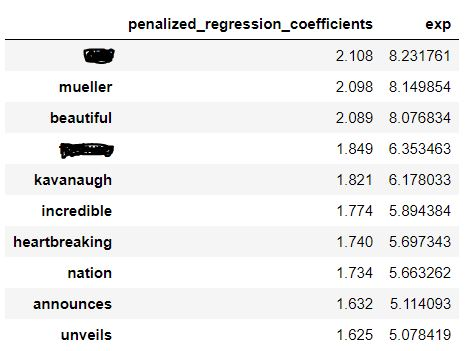

In [7]:
Image("p_coeff.jpg")

In [58]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of shit increase by 1 in a title, that title is 8.23 times as likely to be classified as r/TheOnion.


In [59]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
covid,-2.666,14.382325
manatee,-2.617,13.694578
qanon,-2.590,13.329772
capitol,-2.389,10.902586
vaccine,-2.378,10.783315
bitcoin,-2.362,10.612155
robinhood,-2.355,10.538129
australia,-2.300,9.974182
twitch,-2.253,9.516242
arrested,-2.103,8.190705


In [60]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of covid increase by 1 in a title, that title is 14.38 times as likely to be classified as r/nottheonion.


# Conclusions 

The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialDB. The optimal parameters for this model are where `ngram_range` = (1,3) and `alpha` = 0.36. 
 - Accuracy: 89.72%
 - Precision: 90.87%
 - Recall: 90.02%
 - Specificity: 89.38%
 - Misclassification Rate: 11.11%

To interpret my coefficients, I used my CountVectorizer & Logistic Regression model. 
 - The word that contributes the most positively to being from r/TheOnion is 'incredible' followed by 'questions' and 'heartbreaking'.
   - As occurences of "incredible" increase by 1 in a title, that title is 10.32 times as likely to be classified as r/TheOnion.

- The word that contributes the most positively to being from r/nottheonion is 'australia' followed by 'title' and 'florida'.  
  - As occurences of "australia" increase by 1 in a title, that title is 15.03 times as likely to be classified as r/nottheonion.